# Learning about Jupyter in Jupyter Notebooks 🎉

As always, good to start with some imports.
For this demo, we will be using `ghapi`, `pandas`, `numpy`, and `matplotlib` (oh my!) 

In [1]:
from ghapi.all import GhApi, paged, GhDeviceAuth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we need to create an instance of the API class.

In [ ]:
# If you need to setup an api key for higher rate limits, uncomment the following lines and run them once
ghauth = GhDeviceAuth()
print(ghauth.url_docs())
ghauth.open_browser()

In [6]:


api = GhApi()



Let's call the GitHub API and store the results as a list.
The API results are paged, as some of the data you might ask for could be very long, so we just nest a list comprehension to "flip" through the pages.

In [7]:
api_data = paged(api.repos.list_for_org, org="jupyter")  # type: ignore
jupyter_repos = [r for page in api_data for r in page]

## Process and clean the data with `pandas`

Lists of dictionaries are ok, but let's make that a `pd.DataFrame` so we can more easily work with the data.
Here is also where we can reduce the size of our data by picking out the interesting bits.

In [8]:
interesting_info = [
    "name",
    "html_url",
    "description",
    "homepage",
    "size",
    "stargazers_count",
    "watchers_count",
    "language",
    "forks_count",
    "open_issues_count",
    "license",
    "topics",
    "default_branch",
]

jupyter_df = pd.DataFrame(jupyter_repos, columns=interesting_info)

Now that the DataFrame is loaded, we can use the variable inspector in VS Code to look at the values, even better than printing out the value here.

Let's also use some other tools to explore the data a bit.

In [9]:
# Show stats about numeric columns in the DataFrame
jupyter_df.describe()

,size,stargazers_count,watchers_count,forks_count,open_issues_count
count,90.000000,90.000000,90.000000,90.000000,90.000000
mean,5424.911111,481.822222,481.822222,166.788889,51.233333
std,11140.718424,1920.130418,1920.130418,626.738293,223.027990
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,5.000000,5.000000,9.000000,1.000000
50%,531.000000,18.500000,18.500000,16.500000,4.000000
75%,4562.750000,108.000000,108.000000,57.750000,22.000000
max,52446.000000,13909.000000,13909.000000,3972.000000,2035.000000


In [10]:
jupyter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               90 non-null     object
 1   html_url           90 non-null     object
 2   description        82 non-null     object
 3   homepage           42 non-null     object
 4   size               90 non-null     int64 
 5   stargazers_count   90 non-null     int64 
 6   watchers_count     90 non-null     int64 
 7   language           70 non-null     object
 8   forks_count        90 non-null     int64 
 9   open_issues_count  90 non-null     int64 
 10  license            72 non-null     object
 11  topics             90 non-null     object
 12  default_branch     90 non-null     object
dtypes: int64(5), object(8)
memory usage: 9.3+ KB


In [ ]:
# The license column is an object, but how can we extract the license info...

The license column has dictionary values that would be nice to split out, and get rid of unnecessary info. We can use the autoDocstring extension to help us document the function, and inlay hints can help show inferred missing type hints.

In [11]:
def format_dict_column(data : pd.DataFrame, column : str, mapping : dict):
    split_df = pd.json_normalize(data.loc[:,column]).rename(columns = mapping)  # type: ignore
    return data.drop(column, axis=1).join(split_df.loc[:,list(mapping.values())])

jupyter_df_clean = format_dict_column(jupyter_df, "license", {"key" : "license_key", "name" : "license_name", "url" : "license_url"})

In [12]:
import pandas_profiling
# If you only want to look at numeric columns, you can use the following to filter the DataFrame
# df_numeric = jupyter_df_clean.select_dtypes(include=np.int64)
pandas_profiling.ProfileReport(jupyter_df_clean)# can use minimal=True to reduce output


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Visualizations

In [14]:
language_totals = jupyter_df_clean.groupby("language").sum(numeric_only=True).sort_values("stargazers_count", ascending=False)

<AxesSubplot: ylabel='language'>

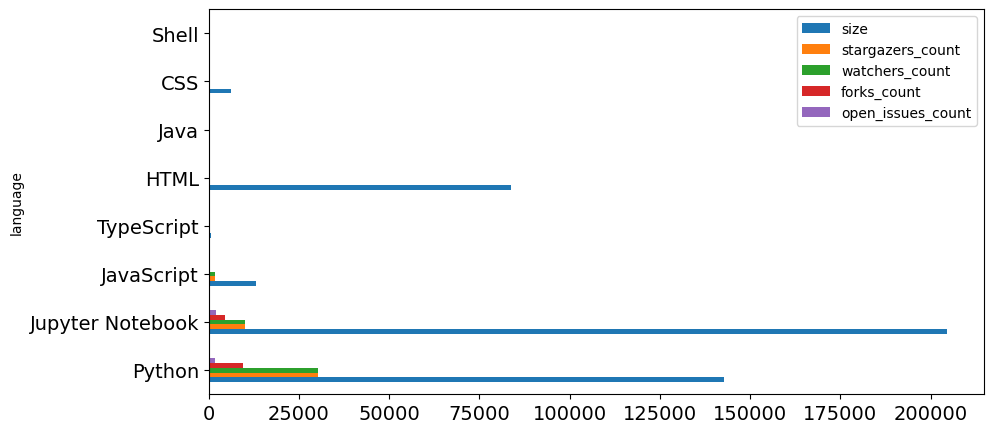

In [17]:
language_totals.plot.barh(figsize=(10, 5), fontsize=14)

---
## Utility

Check you GitHub API limits:

In [5]:
api.rate_limit.get()  # type: ignore

```json
{ 'rate': { 'limit': 60,
            'remaining': 52,
            'reset': 1663372661,
            'resource': 'core',
            'used': 8},
  'resources': { 'core': { 'limit': 60,
                           'remaining': 52,
                           'reset': 1663372661,
                           'resource': 'core',
                           'used': 8},
                 'graphql': { 'limit': 0,
                              'remaining': 0,
                              'reset': 1663376173,
                              'resource': 'graphql',
                              'used': 0},
                 'integration_manifest': { 'limit': 5000,
                                           'remaining': 5000,
                                           'reset': 1663376173,
                                           'resource': 'integration_manifest',
                                           'used': 0},
                 'search': { 'limit': 10,
                             'remaining': 10,
                             'reset': 1663372633,
                             'resource': 'search',
                             'used': 0}}}
```

If the API limit is reached, load from included csv:

In [6]:
# If you need to export the DataFrame to a csv file, you can use the following
# df.to_csv("jupyter_repos.csv")
pd.read_csv("jupyter_repos.csv")

,Unnamed: 0,name,html_url,description,homepage,size,stargazers_count,watchers_count,language,forks_count,open_issues_count,license,topics,default_branch
0,0,nbviewer,https://github.com/jupyter/nbviewer,nbconvert as a web service: Render Jupyter Not...,https://nbviewer.jupyter.org,12473,2015,2015,Python,523,171,"{'key': 'other', 'name': 'Other', 'spdx_id': '...","['jupyter', 'jupyter-notebook', 'nbconvert']",main
1,1,nbconvert-examples,https://github.com/jupyter/nbconvert-examples,Examples that illustrate how nbconvert can be ...,NaN,1678,149,149,Jupyter Notebook,82,9,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
2,2,colaboratory,https://github.com/jupyter/colaboratory,"[deprecated] Jupyter CoLaboratory, goto google...",https://colab.research.google.com,1063,734,734,JavaScript,126,0,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
3,3,jupyter.github.io,https://github.com/jupyter/jupyter.github.io,Project Jupyter's home on the World Wide Web,https://jupyter.org,28975,154,154,HTML,157,18,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...","['homepage', 'jekyll', 'jupyter', 'jupyter-not...",master
4,4,design,https://github.com/jupyter/design,Design related materials for Project Jupyter,NaN,52446,77,77,HTML,57,18,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],master
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,notebook_shim,https://github.com/jupyter/notebook_shim,A shim layer for notebook traits and config,NaN,30,3,3,Python,8,2,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
78,78,try-jupyter,https://github.com/jupyter/try-jupyter,"A JupyterLite deployment to try JupyterLab, Ju...",https://jupyter.org/try-jupyter,39963,4,4,Jupyter Notebook,10,2,NaN,"['ipython', 'jupyter', 'jupyterlab']",main
79,79,team-compass-template,https://github.com/jupyter/team-compass-template,A template for team-compass repositories,NaN,46,0,0,Python,2,1,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
80,80,kernels-team-compass,https://github.com/jupyter/kernels-team-compass,The team-compass for the Jupyter Kernels Subpr...,https://kernels-team-compass.readthedocs.io/en...,22,2,2,NaN,2,0,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",[],main
